# Raneem Ibraheem ID: 212920896
# Aseel Nahhas ID: 212245096

# Code cell 1:

Here we habe the libraries imports that we will be using

Also we check if a gpu exists to run the code on the gpu and not the cpu

<font color= 'red'>Note: you can remove the gpu related lines in order to run the code although not recommended because the data is transferred later on to the gpu, so you need to revert that operation</font>

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)
print("Is CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

c:\Users\Alpha\Desktop\DeepLearning\venv39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch Version: 1.10.2+cu113
CUDA Version: 11.3
Is CUDA Available: True
GPU Name: GeForce GTX 1080
Using device: cuda


# Code cell 2:

start reading the data from the csv files and print a couple samples from the dataset

In [2]:
train_data = pd.read_csv("part1_train.csv", header=None)
test_data = pd.read_csv("part1_test.csv", header=None)
print("Training Data Samples:")
print(train_data.head(2))
print("\nTesting Data Samples:")
print(test_data.head(2))

Training Data Samples:
   0                  1      2           3   4                    5   \
0  39          State-gov  77516   Bachelors  13        Never-married   
1  50   Self-emp-not-inc  83311   Bachelors  13   Married-civ-spouse   

                 6               7       8      9     10  11  12  \
0      Adm-clerical   Not-in-family   White   Male  2174   0  40   
1   Exec-managerial         Husband   White   Male     0   0  13   

               13      14  
0   United-States   <=50K  
1   United-States   <=50K  

Testing Data Samples:
   0         1       2         3   4                    5   \
0  25   Private  226802      11th   7        Never-married   
1  38   Private   89814   HS-grad   9   Married-civ-spouse   

                   6           7       8      9   10  11  12              13  \
0   Machine-op-inspct   Own-child   Black   Male   0   0  40   United-States   
1     Farming-fishing     Husband   White   Male   0   0  50   United-States   

        14  
0   <=5

# Code cell 3:

Here we start by giving the columns names because the dataset doesn't include them. <br>
We do that in order to get the last column from the dataset and then we map it to a nuemrical value, after that we count the values and then we plot them in a bar chart

<font color='red'>Note: some of the lines in each code block could be for debugging, you can ignore the irrelevant outputs</font>


Column Names: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

Unique income values before mapping:
['<=50K' '>50K']

Income Value Counts (Encoded):
income
0    24720
1     7841
Name: count, dtype: int64


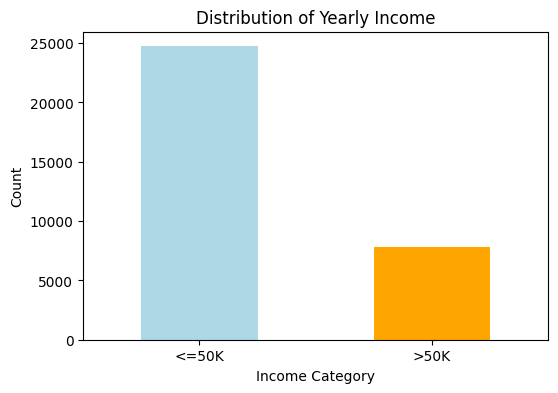

In [3]:
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "gender",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]
train_data.columns = column_names
test_data.columns = column_names

print("\nColumn Names:", train_data.columns)

target_column = "income"
train_data[target_column] = train_data[target_column].astype(str)
train_data[target_column] = train_data[target_column].str.strip().str.replace(".", "", regex=False)

print("\nUnique income values before mapping:")
print(train_data[target_column].unique())

train_data[target_column] = train_data[target_column].map({"<=50K": 0, ">50K": 1})
train_data = train_data.dropna(subset=[target_column])

print("\nIncome Value Counts (Encoded):")
print(train_data[target_column].value_counts())

plt.figure(figsize=(6, 4))
train_data[target_column].value_counts().plot(kind="bar", color=["lightblue", "orange"])
plt.title("Distribution of Yearly Income")
plt.xticks(ticks=[0, 1], labels=["<=50K", ">50K"], rotation=0)
plt.xlabel("Income Category")
plt.ylabel("Count")
plt.show()


# Code cell 4:

Import the needed libraries to start implementing the model

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

# Code cell 5:

In here we start by working on the dataset, we want to have our features as all the columns until the end excluding the income column, and then the target is our income column.
<br>
We also check for irregularities in the dataset, meaning that we check for values that are not complete like some of the data is denoted with the "?" sign.
<br>
Then we want to preprocess the data, so we start by scaling the data to be in the same area by applying a standard scaler like we learned previously in the ML course, Then we split the data to train and validation and after that we convert the data to tensors because pytorch works with tensors. At the end we choose the batch size to be 64.
<br>
<font color='red'>Note: some of the lines in each code block could be for debugging, you can ignore the irrelevant outputs</font>

In [5]:
train_data.replace("?", "Unknown", inplace=True)
test_data.replace("?", "Unknown", inplace=True)

X = train_data.drop(columns=["income"])
y = train_data["income"]

print("Are there any NaN values in target y?", y.isna().sum())

X = pd.get_dummies(X, drop_first=True)
X_test = pd.get_dummies(test_data.drop(columns=["income"]), drop_first=True)

X_test = X_test.reindex(columns=X.columns, fill_value=0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print("Are there any NaN values in y_train?", y_train.isna().sum())
print("Are there any NaN values in y_val?", y_val.isna().sum())

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64, shuffle=False)


Are there any NaN values in target y? 0
Are there any NaN values in y_train? 0
Are there any NaN values in y_val? 0


# Code cell 6:

We start by defining the logistic regression model, we inherit the nn module and then we define the model and the activation function, then we define the forward function.
Also note that we are running the model on the gpu. <br>
We also define the loss function and the optimizer, where we chose the loss function to be a binray cross entropy loss function and we also chose the adam optimizer, because it combines the RMSProb and the momentum, hence gives us a very fast way to optimize the model.<br>
Then we start running epochs to run the model on the data, we train the model, we calculate the loss then we apply the optimizer and then we fix the weights then we call the function that computes the accuracy of the model and we store the values that we got in lists and at the end we just plot the values that are in the lists

LogisticRegressionModel(
  (linear): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch [1/30], Loss: 0.5585, Train Acc: 0.7890, Val Acc: 0.7837
Epoch [2/30], Loss: 0.4435, Train Acc: 0.8271, Val Acc: 0.8285
Epoch [3/30], Loss: 0.3960, Train Acc: 0.8399, Val Acc: 0.8443
Epoch [4/30], Loss: 0.3683, Train Acc: 0.8473, Val Acc: 0.8486
Epoch [5/30], Loss: 0.3514, Train Acc: 0.8494, Val Acc: 0.8500
Epoch [6/30], Loss: 0.3411, Train Acc: 0.8504, Val Acc: 0.8518
Epoch [7/30], Loss: 0.3345, Train Acc: 0.8514, Val Acc: 0.8524
Epoch [8/30], Loss: 0.3305, Train Acc: 0.8513, Val Acc: 0.8546
Epoch [9/30], Loss: 0.3279, Train Acc: 0.8518, Val Acc: 0.8558
Epoch [10/30], Loss: 0.3262, Train Acc: 0.8516, Val Acc: 0.8544
Epoch [11/30], Loss: 0.3250, Train Acc: 0.8520, Val Acc: 0.8555
Epoch [12/30], Loss: 0.3243, Train Acc: 0.8530, Val Acc: 0.8555
Epoch [13/30], Loss: 0.3238, Train Acc: 0.8525, Val Acc: 0.8561
Epoch [14/30], Loss: 0.3235, Train Acc: 0.8530, Val Acc: 0.8558


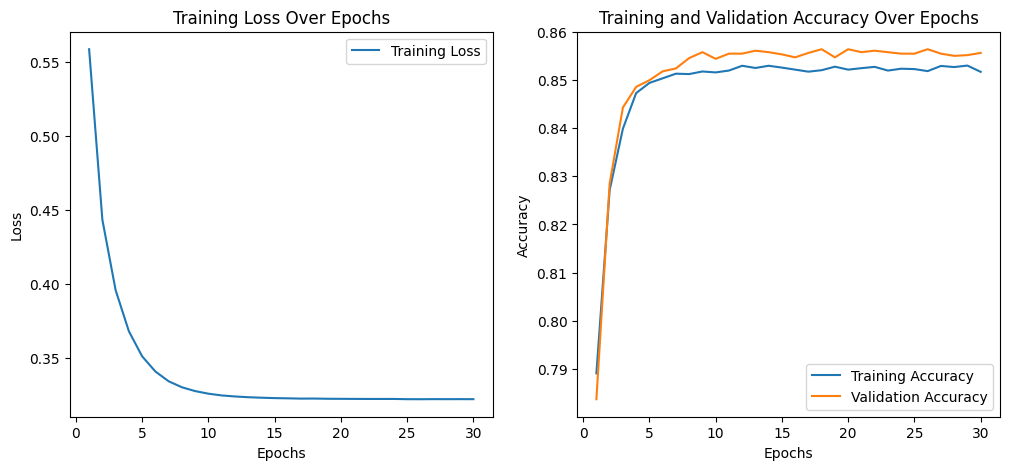


Total model parameters: 101


In [6]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.linear(x))

input_size = X_train_tensor.shape[1]
model = LogisticRegressionModel(input_size).to(device)
print(model)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def compute_accuracy(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            predicted = (outputs > 0.5).float()
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total

num_epochs = 30
train_losses, train_accuracies, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()
plt.show()

total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal model parameters: {total_params}")


# Code cell 7:

We start by importing the libraries and checking if a gpu exists <br>
We then combine a a few preprocessing methods like converting the data to a tensor and normalizing it before we apply it on the data <br>
after that we import the dataset and print how many samples in it

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

print(f"Train Dataset: {len(train_dataset)} samples")
print(f"Test Dataset: {len(test_dataset)} samples")


Using device: cuda
Train Dataset: 60000 samples
Test Dataset: 10000 samples


# Code cell 8:

First we need to get the first 4 categories in the dataset <br>
Then we store them in a subset, and after that we define the batch size to be 64 which is not a big number but also not a small number <br>
And then we convert the subsets to data loaders to efficiently load data in batches <br>
at the end print how many samples we have now in the subset

In [9]:
subset_indices_train = [i for i, (_, label) in enumerate(train_dataset) if label < 4]
subset_indices_test = [i for i, (_, label) in enumerate(test_dataset) if label < 4]

train_subset = Subset(train_dataset, subset_indices_train)
test_subset = Subset(test_dataset, subset_indices_test)

batch_size = 64
train_loader_1 = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader_1 = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

print(f"Network 1 Train Dataset: {len(train_subset)} samples")
print(f"Network 1 Test Dataset: {len(test_subset)} samples")


Network 1 Train Dataset: 24000 samples
Network 1 Test Dataset: 4000 samples


# Code cell 9:

We start by defining the model of the 2 layer network and the relu activation function, the first layer will have the same amount of neurons as the input, then we pass them to a layer with 4 neurons, and we chose 4 because the number of outputs is 4 and our neural network is only an input output network<br>
We then move the model to run on the gpu, and after that we define the optimizer and the loss function, and as we saw in the lectures, the cross entropy loss function works well, and the adam optimizer is great because it combines adagrad and momentum to optimize the network <br>
also at the end we print the number of parameters just to be sure

In [10]:
class Network1(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Network1, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc(x)
        return x

input_size = 28 * 28
num_classes_1 = 4
model_1 = Network1(input_size, num_classes_1).to(device)
print(model_1)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.001)

total_params_1 = sum(p.numel() for p in model_1.parameters())
print(f"Total model parameters in Network 1: {total_params_1}")

Network1(
  (fc): Linear(in_features=784, out_features=4, bias=True)
)
Total model parameters in Network 1: 3140


# Code cell 10:

In the following code cell we define the training function that will run the model and train it over the data then it will run it on the validation set and store all the values in 2 lists <br>
the function will load the images and passes them to the model, then will calculate the loss and apply the optimizer, it will then evaluate the model and store teh results in the lists that we defined <br>
at the end as you can see, we call the function for 20 epochs and train the model and check the performance

In [11]:
def train_and_validate(model, train_loader, test_loader, num_epochs=10):
    train_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = correct / total
        train_losses.append(epoch_loss / len(train_loader))
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Val Acc: {val_accuracy:.4f}")

    return train_losses, val_accuracies

num_epochs = 20
train_losses_1, val_accuracies_1 = train_and_validate(model_1, train_loader_1, test_loader_1, num_epochs)


Epoch [1/20], Loss: 0.2978, Val Acc: 0.9133
Epoch [2/20], Loss: 0.2167, Val Acc: 0.9287
Epoch [3/20], Loss: 0.2049, Val Acc: 0.9243
Epoch [4/20], Loss: 0.1969, Val Acc: 0.9307
Epoch [5/20], Loss: 0.1926, Val Acc: 0.9305
Epoch [6/20], Loss: 0.1888, Val Acc: 0.9297
Epoch [7/20], Loss: 0.1855, Val Acc: 0.9285
Epoch [8/20], Loss: 0.1844, Val Acc: 0.9295
Epoch [9/20], Loss: 0.1820, Val Acc: 0.9310
Epoch [10/20], Loss: 0.1779, Val Acc: 0.9287
Epoch [11/20], Loss: 0.1778, Val Acc: 0.9307
Epoch [12/20], Loss: 0.1774, Val Acc: 0.9200
Epoch [13/20], Loss: 0.1748, Val Acc: 0.9275
Epoch [14/20], Loss: 0.1745, Val Acc: 0.9323
Epoch [15/20], Loss: 0.1736, Val Acc: 0.9300
Epoch [16/20], Loss: 0.1747, Val Acc: 0.9323
Epoch [17/20], Loss: 0.1707, Val Acc: 0.9323
Epoch [18/20], Loss: 0.1727, Val Acc: 0.9315
Epoch [19/20], Loss: 0.1685, Val Acc: 0.9237
Epoch [20/20], Loss: 0.1700, Val Acc: 0.9277


# Code cell 11:

Here we start by defining the network model, which will include 4 layers and the relu activation function, also we chose the hyper parameters in order to have less than 60k network parameters according to the requirements <br>
We also define the forwarding function that will define how the network behaves. It will compress the image to a vector, then will give it to the first layer and activate the relu function, and will continue to do that over all the layers. <br>
We then create a model of the network, with 10 outputs and define the optimizer, and then we define the dataloaders just like before and we call the function that will train and validate the model

In [12]:
class Network2(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Network2, self).__init__()
        self.fc1 = nn.Linear(input_size, 70)
        self.fc2 = nn.Linear(70, 44)
        self.fc3 = nn.Linear(44, 20)
        self.fc4 = nn.Linear(20, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

num_classes_2 = 10
model_2 = Network2(input_size, num_classes_2).to(device)
print(model_2)
optimizer = optim.Adam(model_2.parameters(), lr=0.001)
train_loader_2 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader_2 = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_losses_2, val_accuracies_2 = train_and_validate(model_2, train_loader_2, test_loader_2, num_epochs)

total_params_2 = sum(p.numel() for p in model_2.parameters())
print(f"Total model parameters in Network 2: {total_params_2}")

Network2(
  (fc1): Linear(in_features=784, out_features=70, bias=True)
  (fc2): Linear(in_features=70, out_features=44, bias=True)
  (fc3): Linear(in_features=44, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=10, bias=True)
  (relu): ReLU()
)
Epoch [1/20], Loss: 0.5996, Val Acc: 0.8321
Epoch [2/20], Loss: 0.4136, Val Acc: 0.8479
Epoch [3/20], Loss: 0.3716, Val Acc: 0.8597
Epoch [4/20], Loss: 0.3486, Val Acc: 0.8622
Epoch [5/20], Loss: 0.3298, Val Acc: 0.8673
Epoch [6/20], Loss: 0.3170, Val Acc: 0.8657
Epoch [7/20], Loss: 0.3045, Val Acc: 0.8708
Epoch [8/20], Loss: 0.2926, Val Acc: 0.8692
Epoch [9/20], Loss: 0.2827, Val Acc: 0.8643
Epoch [10/20], Loss: 0.2744, Val Acc: 0.8727
Epoch [11/20], Loss: 0.2693, Val Acc: 0.8706
Epoch [12/20], Loss: 0.2602, Val Acc: 0.8762
Epoch [13/20], Loss: 0.2544, Val Acc: 0.8804
Epoch [14/20], Loss: 0.2470, Val Acc: 0.8741
Epoch [15/20], Loss: 0.2436, Val Acc: 0.8810
Epoch [16/20], Loss: 0.2376, Val Acc: 0.8752
Epoch [17/20], Loss

# Code cell 12:

This code cell only serves as a code snippet that plots the results we got from both of the networks that we built. <br>
The first graph shows the training loss over the epochs, and the second graph shows the accuracy of classification on the validation set over the epochs

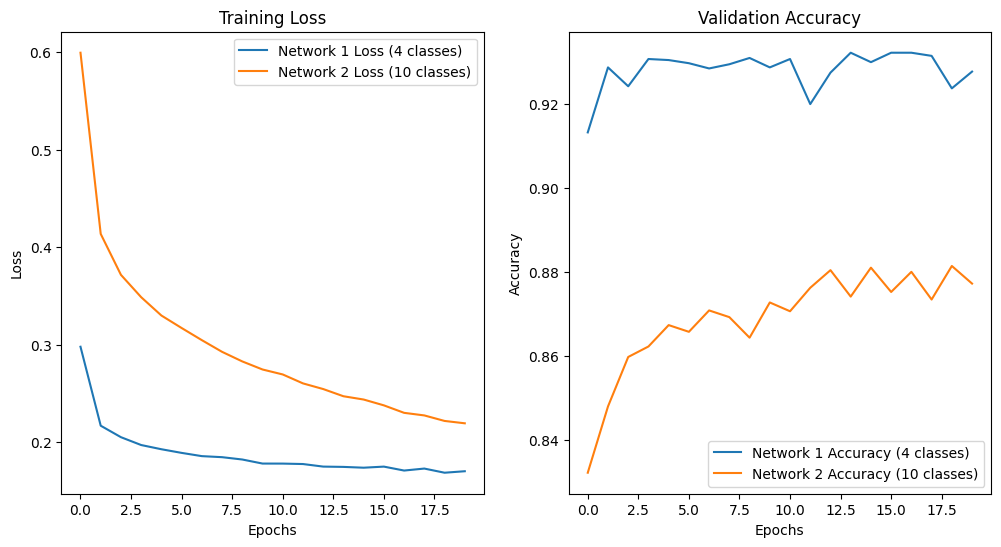

In [13]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses_1, label="Network 1 Loss (4 classes)")
plt.plot(train_losses_2, label="Network 2 Loss (10 classes)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies_1, label="Network 1 Accuracy (4 classes)")
plt.plot(val_accuracies_2, label="Network 2 Accuracy (10 classes)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.show()